In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Préparation des données

In [4]:
# Charger les données
df = pd.read_csv('..\data\dataset_v1_6h.csv')

# Colonnes utilisées comme entrées (features)
feature_columns = [
    'Open_price', 'High_price', 'Low_price', 'Volume', 'Quote_volume',
    'Nb_trades', 'Taker_buy_base_volume', 'Taker_buy_quote_volume',
    '0-6h', '6-12h', '12-18h', '18-23h',
    'lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche',
    'janvier', 'fevrier', 'mars', 'avril', 'mai', 'juin', 'juillet', 'aout',
    'septembre', 'octobre', 'novembre', 'decembre'
]

# Normaliser les données
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

X = scaler_features.fit_transform(df[feature_columns])
y = scaler_target.fit_transform(df[['Close_price']])

# Créer des séquences
def create_sequences(X, y, sequence_length):
    sequences = []
    targets = []
    for i in range(len(X) - sequence_length):
        seq = X[i:i + sequence_length].flatten()  # Aplatir les séquences
        target = y[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 28
X_seq, y_seq = create_sequences(X, y, sequence_length)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)


In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1577, 868), (395, 868), (1577, 1), (395, 1))

# RandomForest

In [5]:
# Définir le modèle
rf = RandomForestRegressor(random_state=42)

# Paramètres pour GridSearch
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [15, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4]
}

# Optimisation des hyperparamètres
grid_rf = GridSearchCV(
    rf, param_grid_rf, scoring='neg_mean_squared_error',
    verbose=1, n_jobs=-1
)
grid_rf.fit(X_train, y_train.ravel())

# Meilleurs paramètres et performances
print("Best parameters (RF):", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"RandomForestRegressor MSE: {mse_rf:.4f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters (RF): {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
RandomForestRegressor MSE: 0.0531


# GradientBoostingRegressor

In [6]:
# Définir le modèle
gbr = GradientBoostingRegressor(random_state=42)

# Paramètres pour GridSearch
param_grid_gbr = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.001],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

# Optimisation des hyperparamètres
grid_gbr = GridSearchCV(
    gbr, param_grid_gbr, scoring='neg_mean_squared_error',
    verbose=1, n_jobs=-1
)
grid_gbr.fit(X_train, y_train.ravel())

# Meilleurs paramètres et performances
print("Best parameters (GBR):", grid_gbr.best_params_)
best_gbr = grid_gbr.best_estimator_
y_pred_gbr = best_gbr.predict(X_test)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
print(f"GradientBoostingRegressor MSE: {mse_gbr:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters (GBR): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
GradientBoostingRegressor MSE: 0.0676


# Réseau de neurones

In [10]:
# Initialiser le modèle de réseau de neurones
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32, 32),  # Deux couches cachées avec 100 et 50 neurones
    activation='relu',            # Fonction d'activation ReLU
    solver='adam',                # Optimiseur Adam
    max_iter=3000,                 # Nombre maximal d'itérations
    random_state=42,
    batch_size= 28,
    learning_rate="constant",
    learning_rate_init=0.001
)

# Entraîner le modèle
mlp.fit(X_train, y_train.ravel())

# Prédictions et évaluation
y_pred_mlp = mlp.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
print(f"MLP MSE: {mse_mlp:.4f}")

MLP MSE: 0.0271


# Visualisation

In [11]:
print(f"MLP MSE: {mse_mlp:.4f}")
print(f"GradientBoostingRegressor MSE: {mse_gbr:.4f}")
print(f"RandomForestRegressor MSE: {mse_rf:.4f}")

MLP MSE: 0.0271
GradientBoostingRegressor MSE: 0.0676
RandomForestRegressor MSE: 0.0531


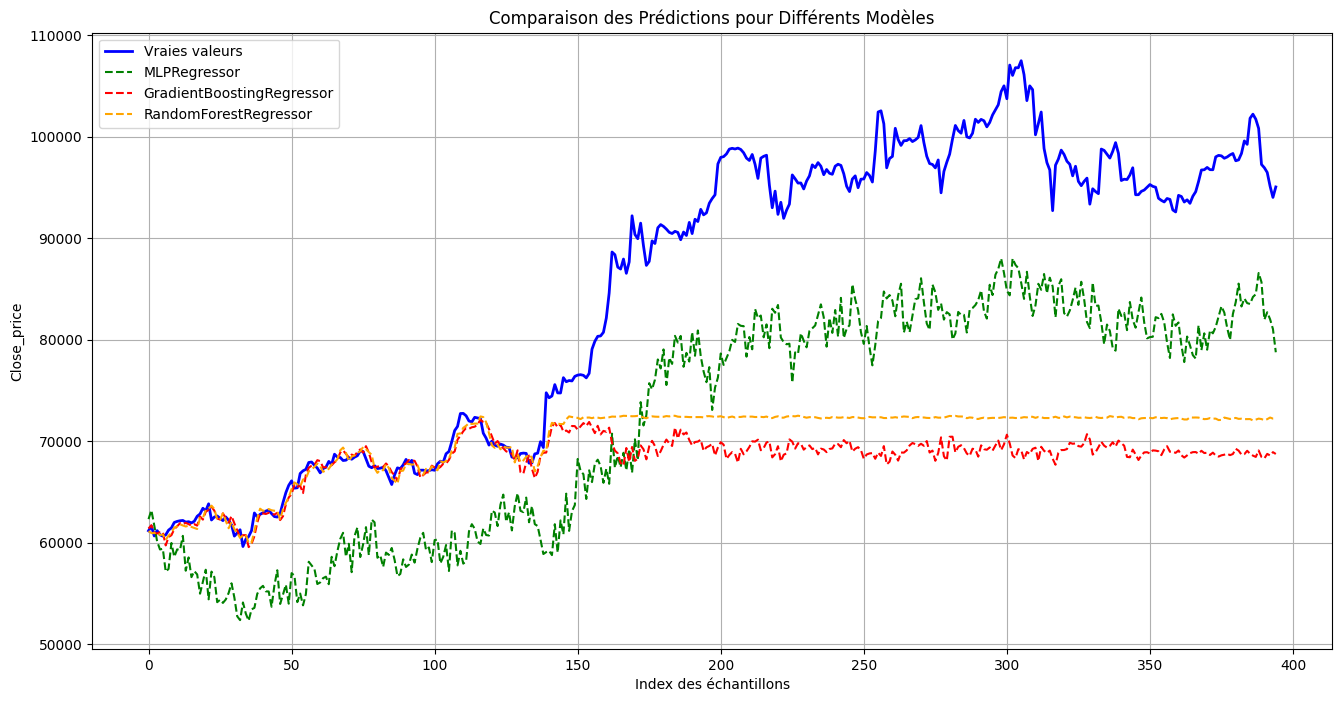

In [13]:
# Dénormaliser les vraies valeurs et les prédictions
y_test_rescaled = scaler_target.inverse_transform(y_test)

y_pred_mlp_rescaled = scaler_target.inverse_transform(y_pred_mlp.reshape(-1, 1))
y_pred_gbr_rescaled = scaler_target.inverse_transform(y_pred_gbr.reshape(-1, 1))
y_pred_rf_rescaled = scaler_target.inverse_transform(y_pred_rf.reshape(-1, 1))

# Tracer les résultats pour chaque modèle
plt.figure(figsize=(16, 8))

# Vraies valeurs
plt.plot(y_test_rescaled, label="Vraies valeurs", color="blue", linewidth=2)

# Prédictions MLP
plt.plot(y_pred_mlp_rescaled, label="MLPRegressor", color="green", linestyle="--")

# Prédictions GradientBoostingRegressor
plt.plot(y_pred_gbr_rescaled, label="GradientBoostingRegressor", color="red", linestyle="--")

# Prédictions RandomForestRegressor
plt.plot(y_pred_rf_rescaled, label="RandomForestRegressor", color="orange", linestyle="--")

# Configuration du graphique
plt.legend()
plt.title("Comparaison des Prédictions pour Différents Modèles")
plt.xlabel("Index des échantillons")
plt.ylabel("Close_price")
plt.grid(True)
plt.show()
